In [116]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [117]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [118]:
df = pd.read_excel('AB_Test_Results.xlsx', sheet_name='AB Test Results')

D:\Soft\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [119]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [120]:
df.shape[0]

10000

In [121]:
df.dtypes

USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object

In [122]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [123]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [124]:
# считаем кол-во наблюдений в каждой группе
df.groupby('VARIANT_NAME').agg({'REVENUE': 'count'})

,REVENUE
VARIANT_NAME,
control,4984
variant,5016


In [ ]:
# Проверим, есть ли пользователи, попавшие в обе группы

In [106]:
countGroups = df.groupby('USER_ID')['VARIANT_NAME'].nunique()

In [107]:
countGroups

USER_ID
2        1
3        2
4        1
5        1
6        1
        ..
9993     1
9995     1
9996     2
9998     1
10000    2
Name: VARIANT_NAME, Length: 6324, dtype: int64

In [108]:
df = df.merge(countGroups, on=["USER_ID", "USER_ID"])

In [109]:
df.head()

,USER_ID,VARIANT_NAME_x,REVENUE,VARIANT_NAME_y
0,737,variant,0.0,1
1,737,variant,0.0,1
2,2423,control,0.0,2
3,2423,control,0.0,2
4,2423,variant,0.0,2


In [115]:
df[df['VARIANT_NAME_y'] == 2].shape[0]

3930

In [84]:
# Исключаем наблюдения у пользователей, попавших в обе группы
df = df[df['VARIANT_NAME_y'] == 1] \
       .rename(columns={'VARIANT_NAME_x': 'VARIANT_NAME'}) \
       .drop('VARIANT_NAME_y', 1)

In [85]:
df.groupby('VARIANT_NAME').agg({'REVENUE': 'count'})

,REVENUE
VARIANT_NAME,
control,3026
variant,3044


In [54]:
df.groupby('VARIANT_NAME').agg({'REVENUE': 'mean'})

,REVENUE
VARIANT_NAME,
control,0.155506
variant,0.058909


In [55]:
df.groupby('VARIANT_NAME').agg({'REVENUE': 'median'})

,REVENUE
VARIANT_NAME,
control,0.0
variant,0.0


<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

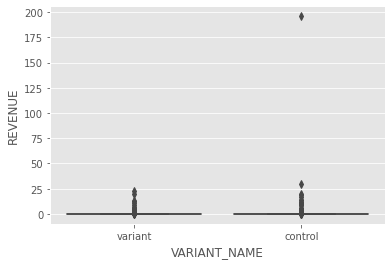

In [56]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

<AxesSubplot:xlabel='REVENUE'>

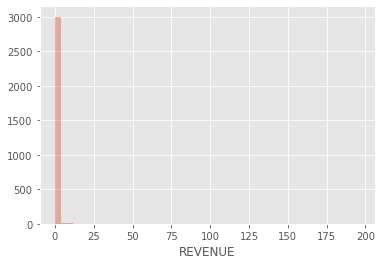

In [58]:
sns.distplot(df[df.VARIANT_NAME == 'control'].REVENUE, kde=False, bins=50)

<AxesSubplot:xlabel='REVENUE'>

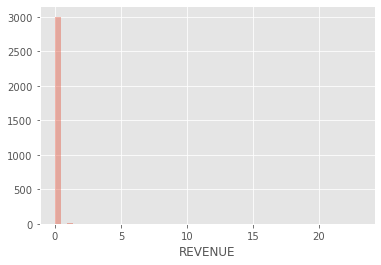

In [59]:
sns.distplot(df[df.VARIANT_NAME == 'variant'].REVENUE, kde=False, bins=50)

In [61]:
# количество "выбросов":
df.query('REVENUE > 50').agg({'VARIANT_NAME': 'count'})

VARIANT_NAME    1
dtype: int64

In [ ]:
# Примем за нулевую гипотезу то, что средние значения в двух группах не различаются. Альтернативная - есть значимые различия

In [62]:
x = df[df.VARIANT_NAME == 'control'].REVENUE

In [63]:
y = df[df.VARIANT_NAME == 'variant'].REVENUE

In [125]:
# Применяем бутстрап

  0%|          | 0/2000 [00:00<?, ?it/s]

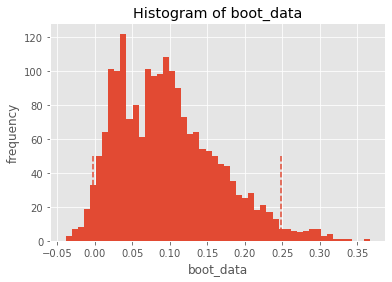

In [67]:
booted_data = get_bootstrap(x, y, boot_it = 2000, statistic = np.mean, bootstrap_conf_level = 0.95)

In [68]:
booted_data["p_value"]

0.14916641732421682

In [69]:
booted_data["ci"]

,0
0.025,-0.002583
0.975,0.248402


In [126]:
# доверительный интервал для разницы средних значений включает 0 и p value > 0.05 => 
# делаем вывод что средние значения стат. значимо  не различаются

In [127]:
# Применяем U-критерий Манна-Уитни
mannwhitneyu(x,y)

MannwhitneyuResult(statistic=4588312.0, pvalue=0.12220868693246068)

## Вывод:

- Часть пользователей попадает в обе группы, необходимо проверить систему сплитования
- Применяя бутстрап с оценкой среднего, мы не можем отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
- U-критерий Манна-Уитни так же не дает нам отклонить нулевую гипотезу